In [25]:
PATH_FRC = ""
DATA_FLAT = './1000_flat_google/*.png'
DATA_NORMAL = './1000_google/*.jpg'
GAUSS_L2_MODEL = './gaussian_l2_1000_noise005/models/3/' #0.05
GAUSS_L2_MODEL_FLAT = './gaussian_l2_flat_1000/models/2/' #0.05

In [3]:
import sys
sys.path.append(PATH_FRC)

import glob
import os
import skimage
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import matplotlib

import tensorflow as tf
from models2 import FRCUnetModel
from skimage.filters import window
from tqdm import tqdm
import pandas as pd

import scipy.stats as stats
from scipy.optimize import fsolve
import pyfftw.interfaces.numpy_fft
np.fft = pyfftw.interfaces.numpy_fft

matplotlib.rcParams.update({'mathtext.default':'regular'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'axes.labelweight': 'bold'})

In [4]:
def normalise_img(image):
    image = image - image.min()
    image = image/image.max() - 0.5
    return image
      
def plot_power_spectrum(image):
    if len(image.shape) == 3:
        image = np.sum(image, axis=2)
        image = image.astype('float64')
        image = image - image.mean()
    fourier_image = np.fft.fftn(image)  # here the input is grey image
    size = image.shape[0]
    fourier_amplitudes = np.abs(fourier_image)**2
    print("FOURIER AMPLITUDES", np.sum(fourier_amplitudes))

    kfreq = np.fft.fftfreq(size) * size  # image size
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, int(size / 2), 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(
        knrm, fourier_amplitudes, statistic="mean", bins=kbins)

    return kvals, Abins 

def load_model(model_dir, model_fname):
    if model_dir is not None:
        return FRCUnetModel(None, model_path=os.path.join(model_dir, model_fname))


In [5]:
files_flat=sorted(glob.glob(DATA_FLAT))
files_flat=files_flat[:50]

In [6]:
files_normal=sorted(glob.glob(DATA_NORMAL))
files_normal=files_normal[:50]

In [7]:
cleans_flat=[]
for file in files_flat:
    clean = imread(file)
    if len(clean.shape) > 2:
        clean = np.mean(clean, axis=2)
    minsize = np.array(clean.shape).min()
    clean = clean[:minsize,:minsize]
    clean = normalise_img(clean)
    clean = clean.astype('float32')
    #clean = clean*window('hann', clean.shape)
    cleans_flat.append(clean)
cleans_flat=np.stack(cleans_flat)

In [8]:
cleans_normal=[]
for file in files_normal:
    clean = imread(file)
    if len(clean.shape) > 2:
        clean = np.mean(clean, axis=2)
    minsize = np.array(clean.shape).min()
    clean = clean[:minsize,:minsize]
    clean = normalise_img(clean)
    clean = clean.astype('float32')
    #clean = clean*window('hann', clean.shape)
    cleans_normal.append(clean)
cleans_normal=np.stack(cleans_normal)

In [10]:
cleans_normal.shape

(50, 256, 256)

In [69]:
noise1=np.random.normal(0,0.05,256**2*50).reshape(50,256,256)
noisy_flat=cleans_flat.copy()+noise1
noise2=np.random.normal(0,0.05,256**2*50).reshape(50,256,256)
noisy_normal=cleans_normal.copy()+noise2

In [67]:
l2_model=load_model(GAUSS_L2_MODEL, 'saved-model-epoch-200')

In [68]:
l2_1000_model_flat=load_model(GAUSS_L2_MODEL_FLAT, 'saved-model-epoch-200')

In [71]:
imnr=3

In [72]:
denoised_normal = l2_model.model(np.reshape(noisy_normal[imnr], [1,256, 256,1]))
denoised_normal = np.squeeze(denoised_normal)

In [73]:
denoised_flat = l2_1000_model_flat.model(np.reshape(noisy_flat[imnr], [1,256, 256,1]))
denoised_flat = np.squeeze(denoised_flat)

In [74]:
x=np.array(plot_power_spectrum(noisy_normal[imnr])[0])
x=x*1.0/x.max()

FOURIER AMPLITUDES 391690718.36664474


FOURIER AMPLITUDES 49332148.0
FOURIER AMPLITUDES 380945660.0
FOURIER AMPLITUDES 60500138.09149456
FOURIER AMPLITUDES 391690718.36664474
FOURIER AMPLITUDES 41253108.0
FOURIER AMPLITUDES 364254340.0


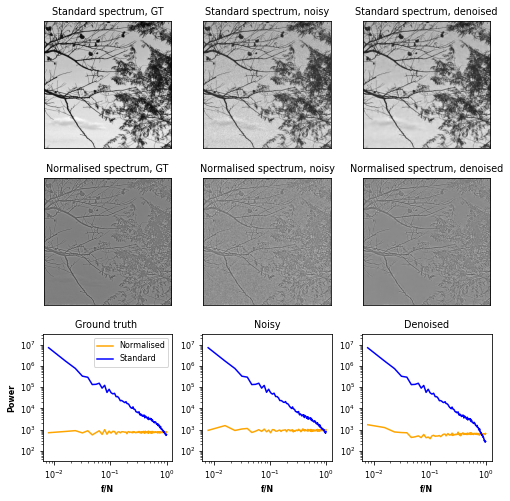

In [75]:
fig = plt.figure()
fig.set_size_inches(7, 7) # 3.5 inch is the width of one column in A4 paper 

ax = fig.add_subplot(334)
ax.imshow(cleans_flat[imnr], cmap='gray')
plt.xticks([])
plt.yticks([])
#plt.ylabel('Gaussian')
plt.title('Normalised spectrum, GT')

ax = fig.add_subplot(335)
ax.imshow(noisy_flat[imnr], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Normalised spectrum, noisy')

ax = fig.add_subplot(336)
ax.imshow(denoised_flat, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Normalised spectrum, denoised')

ax = fig.add_subplot(331)
ax.imshow(cleans_normal[imnr], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Standard spectrum, GT')

ax = fig.add_subplot(332)
ax.imshow(noisy_normal[imnr], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Standard spectrum, noisy')

ax = fig.add_subplot(333)
ax.imshow(denoised_normal, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Standard spectrum, denoised')

ax = fig.add_subplot(337)
plt.title('Ground truth ')
ax.plot(x,np.array(plot_power_spectrum(cleans_flat[imnr])[1]),label='Normalised',color='orange')
ax.plot(x,np.array(plot_power_spectrum(cleans_normal[imnr])[1]),label='Standard',color='blue')
ax.set_xlabel('f/N')
ax.set_ylabel('Power')
plt.yscale('log')
plt.xscale('log')
#ax.locator_params(axis='x', nbins=5)
plt.ylim([10**1.5,10**7.5 ])
plt.legend(loc=1)

ax = fig.add_subplot(338)
plt.title('Noisy')
ax.plot(x,np.array(plot_power_spectrum(noisy_flat[imnr])[1]),label='Normalised',color='orange')
ax.plot(x,np.array(plot_power_spectrum(noisy_normal[imnr])[1]),label='Standard',color='blue')
ax.set_xlabel('f/N')
#ax.set_ylabel('Power')
plt.yscale('log')
plt.xscale('log')
plt.ylim([10**1.5,10**7.5 ])

ax = fig.add_subplot(339)
plt.title('Denoised')
ax.plot(x,np.array(plot_power_spectrum(denoised_flat)[1]),label='Normalised',color='orange')
ax.plot(x,np.array(plot_power_spectrum(denoised_normal)[1]),label='Standard',color='blue')

ax.set_xlabel('f/N')
plt.yscale('log')
plt.xscale('log')
#ax.locator_params(axis='x', nbins=5)
plt.ylim([10**1.5,10**7.5 ])

plt.tight_layout()
plt.subplots_adjust(wspace=0.23, hspace=0.23)
fig.savefig('figure_s3.png', dpi=300)